In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.utils.plotting import plot_series
import math

In [2]:
covid_info = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")
covid_info.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


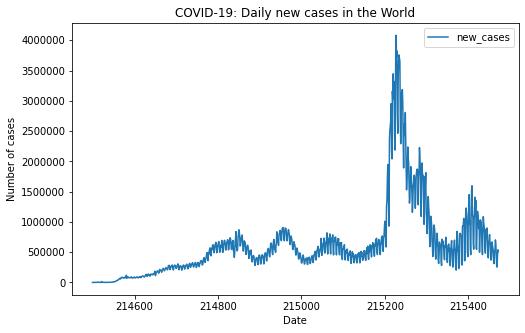

In [3]:
# covid_info[(covid_info['location']=='World')].plot(x='date', y='new_cases', title='COVID-19: Daily new cases', figsize=(8, 5), xlabel = "Date", ylabel="Number of cases")
# plt.ticklabel_format(style='plain', axis='y')
covid_info_world = covid_info[(covid_info['location']=='World')][['new_cases', 'date']]
covid_info_world.plot(figsize=(8, 5), xlabel = "Date", ylabel="Number of cases", title='COVID-19: Daily new cases in the World')
plt.ticklabel_format(style='plain', axis='y')

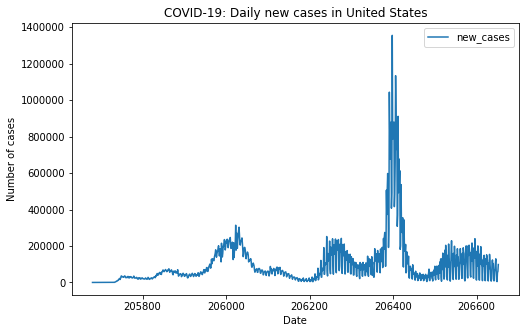

In [4]:
# covid_info[(covid_info['location']=='United States')].plot(x='date', y='new_cases', title='COVID-19: Daily new cases in United States', figsize=(8, 5), xlabel = "Date", ylabel="Number of cases")
# plt.ticklabel_format(style='plain', axis='y')
covid_info_usa = covid_info[(covid_info['location']=='United States')][['new_cases', 'date']]
covid_info_usa.plot(figsize=(8, 5), xlabel = "Date", ylabel="Number of cases", title='COVID-19: Daily new cases in United States')
plt.ticklabel_format(style='plain', axis='y')

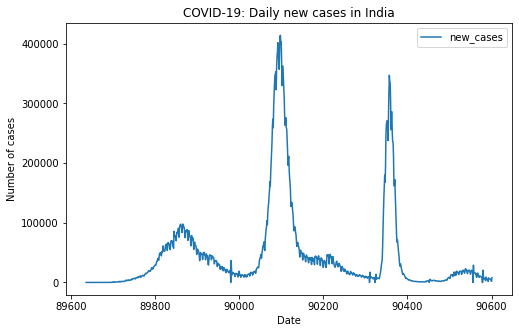

In [5]:
# covid_info[(covid_info['location']=='India')].plot(x='date', y='new_cases', title='COVID-19: Daily new cases in India', figsize=(8, 5), xlabel = "Date", ylabel="Number of cases")
# plt.ticklabel_format(style='plain', axis='y')

covid_info_ind = covid_info[(covid_info['location']=='India')][['new_cases', 'date']]
covid_info_ind.plot(figsize=(8, 5), xlabel = "Date", ylabel="Number of cases", title='COVID-19: Daily new cases in India')
plt.ticklabel_format(style='plain', axis='y')

In [8]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, mean_asymmetric_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller


In [9]:
from sklearn_ts.validator import check_model

In [10]:
model = SARIMAX(covid_info_usa["new_cases"], exog=None, order=(1,2,0), seasonal_order=(0, 1, 0, 12), trend=None)
model_fit = model.fit()
model_fit.params

ar.L1    -3.827157e-01
sigma2    3.006870e+10
dtype: float64

In [11]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          new_cases   No. Observations:                  974
Model:             SARIMAX(1, 2, 0)x(0, 1, 0, 12)   Log Likelihood              -12942.035
Date:                            Thu, 22 Sep 2022   AIC                          25888.070
Time:                                    08:16:37   BIC                          25897.804
Sample:                                         0   HQIC                         25891.777
                                            - 974                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3827      0.009    -44.784      0.000      -0.399      -0.366
sigma2      3.007e+10   3.38e-14    8.9e+23      0.000    3.01e+10    3.01e+10
===================================================================================
Ljung-Box (L1) (Q):                  59.86   Jarque-Bera (JB):             24077.13
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             116.07   Skew:                            -0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [12]:
from sklearn.base import BaseEstimator, RegressorMixin


class SARIMARegressor(BaseEstimator, RegressorMixin):
    # https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

    def __init__(self, order=(1,2,0), seasonal_order=(0, 1, 0, 12)):
        self.order = order
        self.seasonal_order = seasonal_order

        self.model = None
        self.predictions= None
        self.feature_importances_ = [0]

    def fit(self, X, y):
        model = SARIMAX(y, exog=None, order=self.order, seasonal_order=self.seasonal_order, trend=None)
        model_fit = model.fit()
        self.model = model_fit
        return self

    def predict(self, X):
        X = np.ndarray.flatten(X)
        predictions = self.model.get_prediction(start=min(X), end=max(X)).summary_frame()
        self.predictions = predictions[['mean_ci_lower', 'mean_ci_upper']].rename(columns={'mean_ci_lower': 'pi_lower', 'mean_ci_upper': 'pi_upper'})
        return predictions['mean'].values

    def get_params(self, deep=True):
        return {"order": self.order, 'seasonal_order': self.seasonal_order}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [13]:
sr = SARIMARegressor()
sr.fit(covid_info_usa['new_cases'], covid_info_usa['new_cases'])

SARIMARegressor()

{'regressor__order': (4, 1, 4), 'regressor__seasonal_order': (0, 1, 1, 7)}

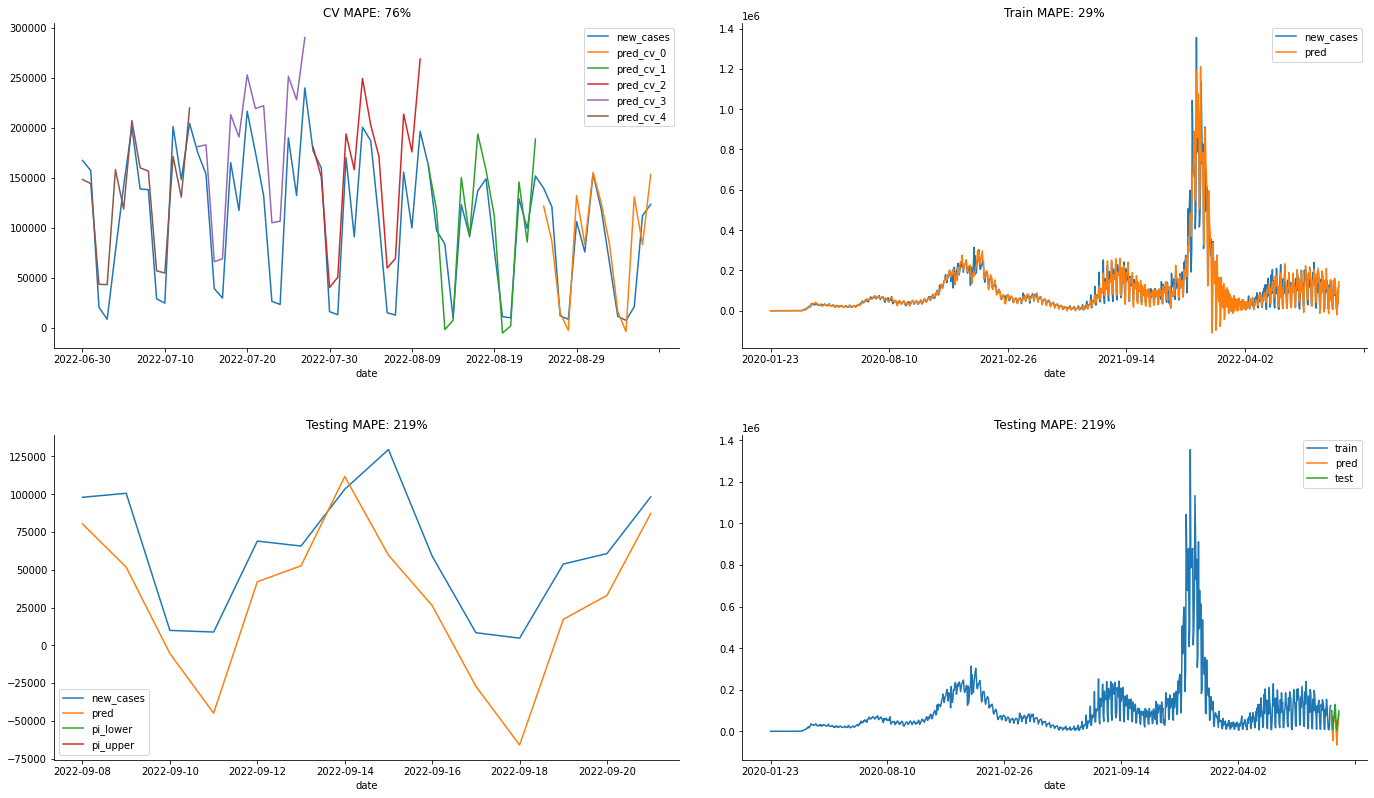

In [14]:
from sklearn_ts.validator import check_model
import warnings
warnings.filterwarnings('ignore')

params = {'order': [(4, 1, 4)], 'seasonal_order': [(0, 1, 1, 7)]}
regressor = SARIMARegressor()

covid_info_usa.index = covid_info_usa['date']

results = check_model(regressor, params, covid_info_usa)
results['best_params']

In [15]:
features = ['year', 'month', f'{15}_lag', f'{15}_lag_rolling', 'dayofweek', 'intercept', 'trend', 'log']
categorical_features = ['year', 'month', 'dayofweek']
numerical_features = [f'{15}_lag', f'{15}_lag_rolling', 'intercept', 'trend', 'log']

covid_info_usa['date'] = pd.to_datetime(covid_info_usa['date'])
covid_info_usa.index = covid_info_usa['date']
covid_info_usa['month'] = covid_info_usa['date'].dt.month
covid_info_usa['year'] = covid_info_usa['date'].dt.year
covid_info_usa['dayofweek'] = covid_info_usa['date'].dt.dayofweek
covid_info_usa[f'{15}_lag'] = covid_info_usa['new_cases'].shift(15)
covid_info_usa[f'rolling_new_cases'] = covid_info_usa['new_cases'].rolling(window=15).mean()
covid_info_usa[f'{15}_lag_rolling'] = covid_info_usa[f'rolling_new_cases'].shift(15)
covid_info_usa['intercept'] = 1
covid_info_usa['trend'] = range(covid_info_usa.shape[0])
covid_info_usa['log'] = covid_info_usa['trend'].apply(lambda x: math.log(x+1))
covid_info_usa = covid_info_usa[['date', 'new_cases'] + numerical_features +categorical_features]
covid_info_usa = covid_info_usa.dropna()
covid_info_usa.head()

,date,new_cases,15_lag,15_lag_rolling,intercept,trend,log,year,month,dayofweek
date,,,,,,,,,,
2020-02-21,2020-02-21,2.0,1.0,0.733333,1,30,3.433987,2020,2,4
2020-02-22,2020-02-22,0.0,0.0,0.733333,1,31,3.465736,2020,2,5
2020-02-23,2020-02-23,0.0,0.0,0.666667,1,32,3.496508,2020,2,6
2020-02-24,2020-02-24,0.0,0.0,0.666667,1,33,3.526361,2020,2,0
2020-02-25,2020-02-25,0.0,0.0,0.466667,1,34,3.555348,2020,2,1


In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
warnings.filterwarnings('ignore')

models = {
    LinearRegression(fit_intercept=False): {'fit_intercept': [False]},

    SVR(): {'C': [50000, 100000], 'kernel': ['rbf']},

    DecisionTreeRegressor(): {'max_depth': [8, 10, 12], 'criterion': ['mae'], 
          'min_samples_split': [4, 8, 10], 'min_samples_leaf': [1, 2]},

    RandomForestRegressor(): {'n_estimators': [100], 'criterion': ['mae'], 
          'max_depth': [8, 15], 'min_samples_split': [2, 3, 4], 
          'random_state': [42], 'min_samples_leaf': [1, 2, 3]},

    XGBRegressor(): {'n_estimators': [100], 'max_depth': [8, 15, 20],'objective': ['reg:squarederror'], 'subsample': [1.0]},

}

results_array = []
for regressor, params in models.items():
  results_array.append(check_model(regressor, params, covid_info_usa, plotting=False, features=features, categorical_features=categorical_features))

pd.DataFrame({'Model': [res['model_name'] for res in  results_array], 'MAPE': [res['performance_test']['MAPE'] for res in  results_array]}).sort_values('MAPE')

,Model,MAPE
4,XGBRegressor,0.350516
2,DecisionTreeRegressor,0.575251
3,RandomForestRegressor,0.780059
1,SVR,2.074122
0,LinearRegression,3.382264


In [17]:
from prophet import Prophet
warnings.filterwarnings('ignore')

covid = covid_info_usa.copy()
covid['ds'] = covid['date']
covid['y'] = covid['new_cases']
m = Prophet(growth='linear', yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
m.add_regressor(f'{15}_lag_rolling')
m.fit(covid)

08:27:52 - cmdstanpy - INFO - Chain [1] start processing
08:27:52 - cmdstanpy - INFO - Chain [1] done processing


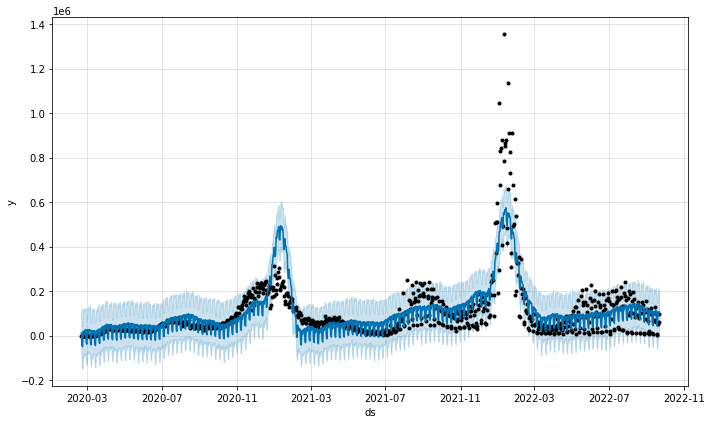

In [18]:
forecast = m.predict(covid)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

figure1 = m.plot(forecast)


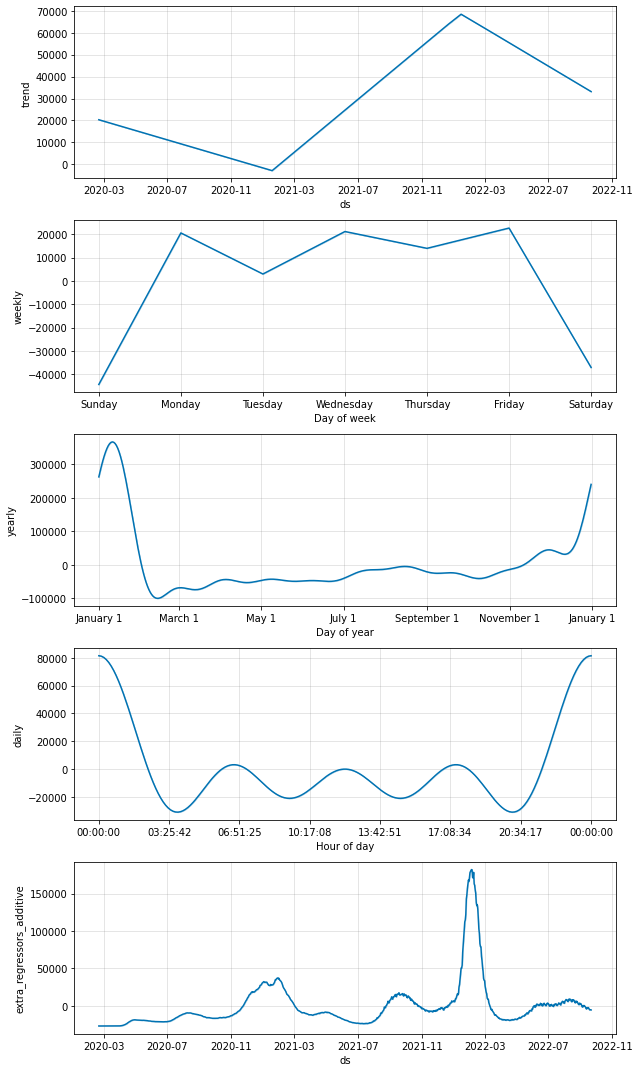

In [20]:
figure2 = m.plot_components(forecast)